In [1]:
import numpy as np
import pandas as pd
from scipy.spatial.transform import Rotation as R

from scipy import optimize
from sklearn.neighbors import KDTree
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.neighbors import BallTree
from tqdm.notebook import tqdm

from readers_writers import *

# Create not optimized membrana

### all functions you need for creating not optimized mem

In [2]:
np.random.seed(41)

def angle(vector_1, vector_2): # find angle between vectors, radian
    unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
    unit_vector_2 = vector_2 / np.linalg.norm(vector_2)
    dot_product = np.dot(unit_vector_1, unit_vector_2)
    return np.arccos(dot_product)

def rotate_system(a: np.array, b: np.array, coord: np.array) -> np.array:
    """
    Parameters
    ----------
    a : rotatable vector
    b : direction vector
    coord : coordinations of our system
    Returns
    -------
    System will be rotate at the same angle as we rotate vector a to make it parallel with vector b
    """
    if np.linalg.norm(np.cross(a, b)) == 0: # calc mult vector, in case of parallel vector we choose any normal vector
        if a[0] == 0:
            rv = [np.pi, 0, 0]
        else:
            rv = np.array([-(a[1]+a[2])/a[0], 1, 1])/np.linalg.norm([-(a[1]+a[2])/a[0], 1, 1]) * np.pi
    else:
        rv = np.cross(a, b)/np.linalg.norm(np.cross(a, b)) * angle(a, b)
    
    r = R.from_rotvec(rv)
    return r.apply(coord)


# |------------------------- build membrana -------------------------|
def add_mol(df, system, r_c, i=0, j=0):
    """
    add base molecule to system 

    Args:
        df (pd.DataFrame): initial molecule in 0 0 0 coords
        system (list): list with molecules in layer
        r_c (_type_): step to put molecules
        i (int, optional): row number of mol. Defaults to 0.
        j (int, optional): col number of mol. Defaults to 0.

    Returns:
        pd.DataFrame: df with system
    """
    new_mol = df.copy()
    random_angle = np.random.random()*360
    r = R.from_euler('x', random_angle, degrees=True)
    new_mol[['x', 'y', 'z']] = r.apply(new_mol[['x', 'y', 'z']])
    new_mol[['x', 'y', 'z']] += np.array([0, r_c, r_c]) * np.array([0, i, j])
    new_mol['resnum'] = system.resnum.iloc[-1] + 1
    return pd.concat([system, new_mol])


def make_layer(molecules, system, r_c=14.5, d_y=7, d_z=7):
    """create layer from list of molecules

    Args:
        molecules (list): list of initial molecules in 0 0 0 coords
        system (_type_): molecule in 0 0 position
        r_c (float, optional): step size. Defaults to 14.5.
        d_y (int, optional): number of rows. Defaults to 7.
        d_z (int, optional): number of columns. Defaults to 7.

    Returns:
        pd.DataFrame: layer d_y * d_z size with step = r_c
    """
    n = 1
    for i in tqdm(range(d_y)):
        for j in range(d_z):
            if i+j == 0:
                continue
            system = add_mol(molecules[i][j], system, r_c, i=i, j=j)
            n += 1
    
    system['atnum'] = np.arange(1, system.shape[0] + 1)
    return system


def gen_layers_pattern(k=6, eu=70, w=30):
    """generate layers pattern due to not put W conformation above another W conf

    Args:
        k (int, optional): layer size (k*k). Defaults to 6.
        eu (int, optional): number of eu conformations. Defaults to 70.
        w (int, optional): number of w conformations Defaults to 30.

    Returns:
        tuple: tuple of np.arrays with patterns
    """
    pattern_layer0 = [0 for i in range(eu)] + [1 for i in range(w)]
    np.random.shuffle(pattern_layer0)
    pattern_layer0 = np.array(pattern_layer0)
    pattern_layer1 = np.where(pattern_layer0 == 1, 0, 1)
    idx = np.argwhere(pattern_layer1 == 1)
    np.random.shuffle(idx)
    idx = idx[:eu - w]
    pattern_layer1[idx] = 0
    pattern_layer0, pattern_layer1 = pattern_layer0.reshape((k, k)), pattern_layer1.reshape((k, k))
    pattern_layer0 = pattern_layer0[:, ::-1]
    return pattern_layer0, pattern_layer1

# |-----------for optimize molecule location -------------|

def e(df):
    """calc maximum distance from 0X axis for molecule

    Args:
        df (pd.DataFrame): df with molecule

    Returns:
        float: max distance
    """
    return (((df.z**2 + df.y**2))**0.5).max()

def rotate_system_foropt(angles, df):
    """rotate molecule by euler angles put your molecule in  0 0 0 coords! 

    Args:
        angles (np.array): anlges in degree
        df (pd.DataFrame): molecule

    Returns:
        _type_: _description_
    """
    r = R.from_euler('xyz', angles, degrees=True)
    df[['x', 'y', 'z']] = r.apply(df[['x', 'y', 'z']])
    return df

def f(angles, df):
    """calc max distance from 0X axis for current angles

    Args:
        angles (np.array): ueler angles in degree
        df (pd.DataFrame): molecule

    Returns:
        float: max distance from 0X axis
    """
    dft = df.copy()
    dft = rotate_system_foropt(angles, dft)
    return e(dft)

def rotate_system_opt(df):
    """ find optimal position of molecule

    Args:
        df (pd.DataFrame): molecule

    Returns:
        pd.DataFrame: optimized position of molecule
    """
    lw = [-90] * 3
    up = [90] * 3
    bounds=list(zip(lw, up))
    res = optimize.dual_annealing(f, bounds=bounds, maxiter=100, args=(df,))
    
    df = rotate_system_foropt(res.x, df)
    print(e(df))
    return df


# |--------------system info---------------|
def calc_p_fromgro(df, nbin=100, axis='z'):
    """integral density calculation distance in 

    Args:
        df (pd.DataFrame): df with system, DONT FORGET ADD MASSES
        nbin (int, optional): number of bins. Defaults to 100.
        axis (str, optional): integral dens along this axis. Defaults to 'z'.

    Returns:
        pd.DataFrame: df with density (kg/m3)
    """
    gg = df[['x', 'y', 'z']].max() - df[['x', 'y', 'z']].min()
    
    df['bin'] = pd.cut(df[axis], bins=nbin)
    v = df.bin.iloc[0].length * gg[0] * gg[1]
    gg = df.groupby('bin').agg(
                            m=('m', 'sum')
                            ).reset_index()
    v = v/1000
    gg['p'] = gg['m'] / v * 1.66
    gg[axis] = gg.bin.apply(lambda x: x.mid).astype(np.float32)
    return gg

def system_info(system):
    """show integral density along x axis and minimal distances res - system 
    for 10 residues with smallest distances

    Args:
        system (_type_): _description_
    """
    min_distances = []
    for resnum in tqdm(system.resnum.unique()):
        tree = BallTree(system.loc[system.resnum != resnum, ['x', 'y', 'z']], leaf_size=3)
        dist, idx = tree.query(system.loc[system.resnum == resnum, ['x', 'y', 'z']], k=1)
        min_distances.append(dist.min())

    min_distances.sort()
    print(min_distances[:10])
    masses = {'H': 1, 'C': 12, 'N': 14, 'O': 16}
    system['m'] = system.atType.apply(lambda x: masses[x])
    p = calc_p_fromgro(system, 30, 'x')
    p.plot(x='x', y='p')



In [3]:
# |------------------------ lets ROCK! ------------------ |
# read molecules and rotate them as it is needed by guiding atoms

df = read_pdb('files/AMA_charmm.pdb', ) 
atoms = (df[df.atom == 'O81'].index[0],
         df[df.atom == 'C70'].index[0])

df.loc[:, ['x', 'y', 'z']] = df.loc[:, ['x', 'y', 'z']] - df.loc[[atoms[0]], ['x', 'y', 'z']].values
df[['x', 'y', 'z']] = rotate_system(df.loc[[atoms[1]], ['x', 'y', 'z']], np.array([1, 0, 0.]), df[['x', 'y', 'z']])
df[['x', 'y', 'z']] -= df[['x', 'y', 'z']].mean()

df1 = read_pdb('files/AMA_eU.pdb')
atoms = (df1[df1.atom == 'O81'].index[0],
         df1[df1.atom == 'C70'].index[0]) 

df1.loc[:, ['x', 'y', 'z']] = df1.loc[:, ['x', 'y', 'z']] - df1.loc[[atoms[0]], ['x', 'y', 'z']].values
df1[['x', 'y', 'z']] = rotate_system(df1.loc[[atoms[1]], ['x', 'y', 'z']], np.array([1, 0, 0.]), df1[['x', 'y', 'z']])
df1[['x', 'y', 'z']] -= df1[['x', 'y', 'z']].mean()

df2 = read_pdb('files/AMA_charmm.pdb', ) 
atoms = (df[df.atom == 'O81'].index[0],
         df[df.atom == 'C70'].index[0])

df2.loc[:, ['x', 'y', 'z']] = df2.loc[:, ['x', 'y', 'z']] - df2.loc[[atoms[0]], ['x', 'y', 'z']].values
df2[['x', 'y', 'z']] = rotate_system(df2.loc[[atoms[1]], ['x', 'y', 'z']], np.array([1, 0, 0.]), df2[['x', 'y', 'z']])
df2[['x', 'y', 'z']] -= df2[['x', 'y', 'z']].mean()



# choose the best rotation
df = rotate_system_opt(df)
df1 = rotate_system_opt(df1)
df2 = rotate_system_opt(df2)

# move kma and mma a little bit
df['x'] -= 7
df2['x'] -= 7


7.381585291061873
5.453522493875912
7.3794197555634025


In [4]:
# In some membranes, we cannot place 
# some molecules on top of others.

mem_size = 10
pattern_layer0, pattern_layer1 = gen_layers_pattern(mem_size, 50, 50)

In [5]:
pattern_layer0 = [list(i) for i in pattern_layer0]
pattern_layer1 = [list(i) for i in pattern_layer1]

for arr in pattern_layer0, pattern_layer1:
    eu = [df1.copy() for _ in range(50)] 
    w = [df.copy() for _ in range(25)] + [df2.copy() for _ in range(25)]
    np.random.shuffle(w)
    for i in range(len(arr)):
        for j in range(len(arr[0])):
            if arr[i][j] == 0:
                arr[i][j] = eu.pop()
            else:
                arr[i][j] = w.pop()

# Create box and show parametres

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

[0.04268974307909276, 0.04268974307909276, 0.07989297359251381, 0.07989297359251381, 0.0799313279937955, 0.0799313279937955, 0.09850977776944908, 0.09850977776944908, 0.11429836193708456, 0.11429836193708456]


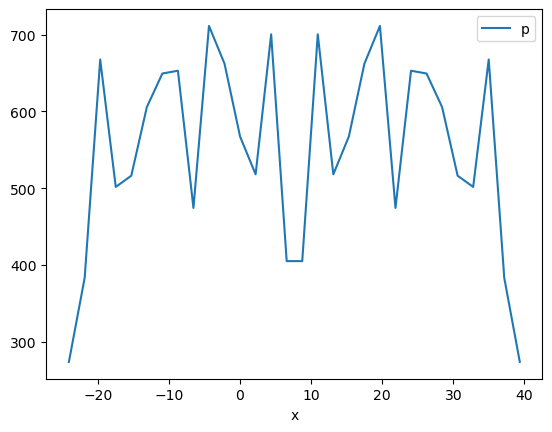

In [6]:
layer0 = make_layer(pattern_layer0, pattern_layer0[0][0], 15.5, mem_size, mem_size)
layer1 = make_layer(pattern_layer1, pattern_layer1[0][0], 15.5, mem_size, mem_size)

r = R.from_euler('y', 180, degrees=True)
mean = layer1[['x', 'y', 'z']].mean()
layer1.loc[:, ['x', 'y', 'z']] -= mean
layer1.loc[:, ['x', 'y', 'z']] = r.apply(layer1[['x', 'y', 'z']])
layer1.loc[:, ['x', 'y', 'z']] += mean
layer1['x'] += layer0.x.max() - layer1.x.min()
layer1['resnum'] += layer0.resnum.max()



penetration_rate = 55
layer1['x'] -= penetration_rate
system = pd.concat([layer0, layer1])

masses = {'H': 1, 'C': 12, 'N': 14, 'O': 16}
system['m'] = system.atType.apply(lambda x: masses[x])

system_info(system)


system.to_csv('not_opt.csv', index=False)

# Optimization of membana
I use dual anneling, lennard - johnes potential as optimizer 
parametres - angles and movments of molecule

In [7]:
%%time
def choose_res(df, resnum):
    """return chosen res and system without the res
    Args:
        df (pd.DataFrame): system
        resnum (_type_): number of chosen res

    Returns:
        tuple: system, res
    """
    res = df.loc[df.resnum == resnum, ['x', 'y', 'z']].values
    system = df.loc[df.resnum != resnum, ['x', 'y', 'z']].values
    return system, res


def make_tree(system):
    return BallTree(system, leaf_size=3)


def calc_dist(tree, X):
    """return distances 
     for 4 closest neib
    distances = { distances, distances < 4
                4, distances >= 4}
    Args:
        tree (BallTree): tree for system
        X (np.array): coords of res

    Returns:
        np.array: arr of distances
    """
    dist, _ = tree.query(X, k=10)
    dist = np.where(dist < 4, dist, 4)
    return dist

d = 3.5
sig = d / 2**(1/6)
e = 1e1
pot612 = lambda r: 4*e*( (sig/r)**12 - (sig/r)**6 )

def E(dist):
    return pot612(dist).sum()


def move_rot(X, res):
    """rotate and move residue

    Args:
        X (np.array): ueler degree along x axis, dx, dy, dz move
        res (_type_): _description_

    Returns:
        _type_: _description_
    """
    res = res.copy()
    r = R.from_euler('x', X[0], degrees=True)
    res_mean = res.mean(axis=0)
    res -= res_mean
    res = r.apply(res)
    res += res_mean
    res += X[1:]
    return res


def f(X, res, tree):
    """move residue and calc energy

    Args:
        X (np.array): parametres of moving and rotation
        res (np.array): coords of residue
        tree (BallTree): tree of balltree of system

    Returns:
        float: energy
    """
    new_res = move_rot(X, res)
    return E(calc_dist(tree, new_res))



def opt(df, res_to_opt, nit=1000):
    """ optimization of res_to_opt position

    Args:
        df (pd.DataFrame): system with all reses
        res_to_opt (int): number of optimized res
        nit (int, optional): maximum number of iteration in dual anneling optimization. Defaults to 1000.

    Returns:
        _type_: _description_
    """
    system, res = choose_res(df, res_to_opt)
    tree = make_tree(system)
    lw = [0, -1.5, -1.5, -0.05]
    up = [360, 1.5, 1.5, 0.05]
    bounds=list(zip(lw, up))
    result = optimize.dual_annealing(f, bounds=bounds, maxiter=nit, args=(res, tree))
    new_res = move_rot(result.x, res)
    new_df = df.copy()
    new_df.loc[new_df.resnum == res_to_opt, ['x', 'y', 'z']] = new_res
    i = res_to_opt
    dft0 = df.loc[df.resnum == i, ['x', 'y', 'z']]
    dft1 = df.loc[df.resnum != i, ['x', 'y', 'z']]
    d_old = euclidean_distances(dft0, dft1).min()
    dft0 = new_df.loc[new_df.resnum == i, ['x', 'y', 'z']]
    dft1 = new_df.loc[new_df.resnum != i, ['x', 'y', 'z']]
    d_new = euclidean_distances(dft0, dft1).min()
    if d_old < d_new:
        return new_df
    # print('FAIL')
    return df


df = pd.read_csv('not_opt.csv')

gg = df.groupby('resnum').agg(x=('x', 'mean'), y=('y', 'mean'), z=('z', 'mean')).reset_index()
print(len(set(gg.query('y > 135 or y < 3 or z > 135 or z < 3').resnum)))
for j in range(10):
    for i in tqdm(range(1, 201)):
        if i not in set(gg.query('y > 135 or y < 3 or z > 135 or z < 3').resnum):
            df = opt(df, i, 200)
    df.to_csv(f'files/w_{j}.csv')

72


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Wall time: 1h 52min 5s


  0%|          | 0/200 [00:00<?, ?it/s]

[0.14819239042287452, 0.14819239042287452, 0.1676977021758051, 0.1676977021758051, 0.168802930175528, 0.168802930175528, 0.17519944075299895, 0.17519944075299895, 0.18981474208674246, 0.18981474208674246]


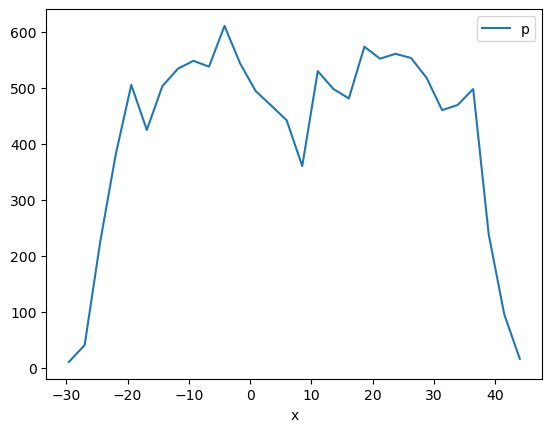

In [9]:
system_info(df)

In [13]:
write_pdb(df, 'new_shit.pdb')

In [23]:
from biopandas.pdb import PandasPdb
import py3Dmol 
with open('new_shit.pdb') as ifile:
    protein = "".join([x for x in ifile])

view = py3Dmol.view(width=800, height=600) 
view.addModelsAsFrames(protein)
style = {'cartoon': {'color': 'spectrum'},'stick':{}}
view.setStyle({'model': -1}, style) 
view.zoom(0.12)
view.rotate(235, {'x':10,'y':10,'z':10})
view.spin({'x':-0.2,'y':0.5,'z':0},0)
view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [11]:
def get_res(df, res_name):
    res = df[df.res == res_name].copy()
    num_atoms = res.groupby('resnum').atnum.count().iloc[0]
    num_mols = int(res.shape[0]/num_atoms)
    resnum = (np.ones((num_mols, num_atoms)) * np.arange(1, num_mols+1)[:, np.newaxis]).flatten()
    res['resnum'] = resnum
    return res.astype({'resnum': np.uint16})

ama = get_res(df, 'AMA')
mma = get_res(df, 'MMA')
kma = get_res(df, 'KMA')
df_ordered = pd.concat([ama, mma, kma])
df_ordered['atnum'] = np.arange(1, df_ordered.shape[0] + 1)
cols_order = df_ordered.columns
df_ordered = df_ordered.rename(columns={'y': 'x', 'x': 'z', 'z': 'y'})[cols_order]
write_pdb(df_ordered, 'new_shit.pdb')

IndexError: single positional indexer is out-of-bounds

### Finally we have got this:

<img src="membrana.png">